## SETUP

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import fastai
from fastai.vision import *
import tqdm

In [3]:
# show versions
print('fastai:', fastai.__version__)
print('pytorch:', torch.__version__)
print('python:', sys.version.split(' ')[0])

fastai: 1.0.48
pytorch: 1.0.1.post2
python: 3.6.7


In [4]:
version = 'v1'       # this should match the notebook filename

seed = 42
arch = models.resnet50
size = (217, 223)  # (y, x)
bs = 32
num_workers = 6    # set to available cores

In [5]:
# set seed
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## DATA

Assumes the following hab been generated using `gen_spectogram`:
- `X_train.csv`
- `y_train.csv`
- `train_images`
- `test_images`

In [6]:
path = pathlib.Path.home()/'.fastai/data/earthquake'
path.ls()

[PosixPath('/root/.fastai/data/earthquake/sample_submission.csv'),
 PosixPath('/root/.fastai/data/earthquake/test.zip'),
 PosixPath('/root/.fastai/data/earthquake/train.csv.zip'),
 PosixPath('/root/.fastai/data/earthquake/train.csv'),
 PosixPath('/root/.fastai/data/earthquake/train'),
 PosixPath('/root/.fastai/data/earthquake/test')]

In [74]:
# look at images dir
img_path = path/'train_images'
img_path.ls()[:5]

[PosixPath('/root/.fastai/data/earthquake/train_images/seg_0.png'),
 PosixPath('/root/.fastai/data/earthquake/train_images/seg_1.png'),
 PosixPath('/root/.fastai/data/earthquake/train_images/seg_2.png'),
 PosixPath('/root/.fastai/data/earthquake/train_images/seg_3.png'),
 PosixPath('/root/.fastai/data/earthquake/train_images/seg_4.png')]

In [9]:
# look at saved models dir
save_path = path/'saved_models'
if not os.path.isdir(save_path):
    os.mkdir(save_path)
save_path.ls()[:5]

[]

In [24]:
# load segment csvs
pd.options.display.precision = 15
X_train = pd.read_csv(path/'X_train.csv', index_col=0)
y_train = pd.read_csv(path/'y_train.csv', index_col=0)

In [25]:
X_train.head()

,ave,std,max,min
0,4.884113333333334,5.101089126891323,104.0,-98.0
1,4.725766666666667,6.588801819164258,181.0,-154.0
2,4.906393333333333,6.967373808828945,140.0,-106.0
3,4.902240000000000,6.922282112791033,197.0,-199.0
4,4.908720000000000,7.301085852684289,145.0,-126.0


In [26]:
y_train.head()

,time_to_failure
0,1.4307971859
1,1.3914988931
2,1.3531960947
3,1.3137978019
4,1.2743995091


## MODEL

In [101]:
def gen_label(path):
    id = int(path.name.split('_')[1].split('.')[0])
    ttf = y_train.iloc[id]['time_to_failure']
    return tensor(ttf).float()

In [ ]:
gen_label(img_path/'seg_0.png')

In [102]:
# no data augmentation
tfms = get_transforms(do_flip=False, p_affine=0., p_lighting=0.)

In [103]:
fake_label = tensor([0.])
src = (ImageList.from_folder(img_path)
        .split_by_rand_pct(valid_pct=0.10)
        .label_from_func(gen_label, label_cls=FloatList)
        .add_test_folder('../test_images', label=fake_label))

In [104]:
data = (src.transform(tfms, resize_method=ResizeMethod.NO, size=size)
        .databunch(bs=bs, num_workers=num_workers)
        .normalize(imagenet_stats))

In [105]:
# verify datasets loaded properly
n_train_items = len(data.train_ds)
n_valid_items = len(data.valid_ds)
n_test_items = len(data.test_ds)

print('train: ', n_train_items)
print('valid: ', n_valid_items)
print('test:  ', n_test_items)
print('')
print('TOTAL: ', n_train_items + n_valid_items + n_test_items)

train:  3464
valid:  384
test:   2624

TOTAL:  6472


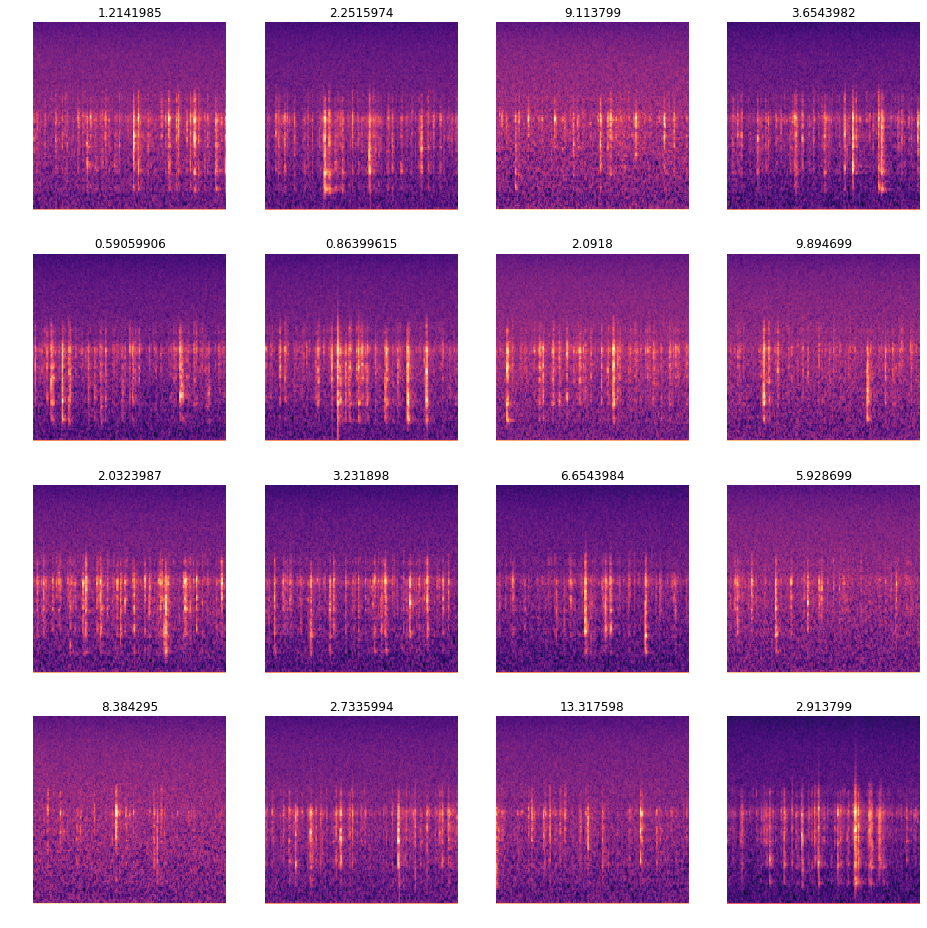

In [109]:
# verify images and labels match up
data.show_batch(4, figsize=(13, 13))

In [110]:
# just rename
def mse(preds, targs):
    return mean_squared_error(preds, targs)

# just rename
def mae(preds, targs):
    return mean_absolute_error(preds, targs)

In [126]:
# L1 loss is sum of the all the absolute differences
# more robust to outliers
l1loss = nn.L1Loss()
def l1_loss(preds, targs):
    return l1loss(preds, targs)

# L2 loss is sum of the all the squared differences
# less robust to outliers
l2loss = nn.MSELoss()
def l2_loss(preds, targs):
    return l2loss(preds, targs)

In [127]:
# return correct size of fully connected layer based on pre-trained model
def final_conv_layer_size(arch):
    if arch == models.resnet18 and size == (217, 223): return 512*14*21
    elif arch == models.resnet34 and size == (217, 223): return 512*7*7  
    elif arch == models.resnet50 and size == (217, 223): return 2048*7*7

In [128]:
# define linear layer that maps final conv layer to output
head_reg1 = nn.Sequential(Flatten(), nn.Linear(final_conv_layer_size(arch), 1))

In [129]:
learn = cnn_learner(data, arch, custom_head=head_reg1, loss_func=l1_loss, metrics=[mse, mae])

In [130]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [1, 64, 109, 112]    9,408      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 109, 112]    128        True      
______________________________________________________________________
ReLU                 [1, 64, 109, 112]    0          False     
______________________________________________________________________
MaxPool2d            [1, 64, 55, 56]      0          False     
______________________________________________________________________
Conv2d               [1, 64, 55, 56]      4,096      False     
______________________________________________________________________
BatchNorm2d          [1, 64, 55, 56]      128        True      
______________________________________________________________________
Conv2d               [1, 64, 55, 56]      36,864     False     
______________________________________________________________

## TRAIN

#### Stage 1-1

In [131]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


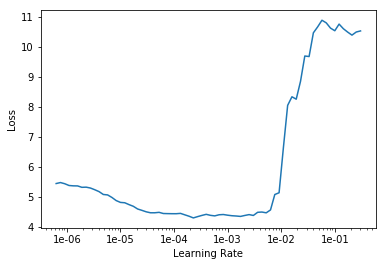

In [132]:
learn.lr_find()
learn.recorder.plot()

In [133]:
learn.fit_one_cycle(10, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,mse,mae,time
0,3.354089,4.404176,29.730600,4.387906,00:14
1,3.489782,3.142993,15.594428,3.173294,00:14
2,4.174018,4.252661,25.356657,4.165946,00:14
3,4.423065,3.256358,17.550619,3.427160,00:14
4,3.891730,3.197455,15.487468,3.200156,00:14
5,3.905005,3.121352,13.865135,3.041780,00:14
6,3.370276,3.056421,13.813394,3.031448,00:14
7,3.262426,3.087146,15.029389,3.185900,00:14
8,3.151303,3.059899,14.277653,3.077330,00:14
9,3.140718,3.056733,14.457057,3.105171,00:14


In [134]:
learn.save(save_path/f'{version}-stage-1-1')

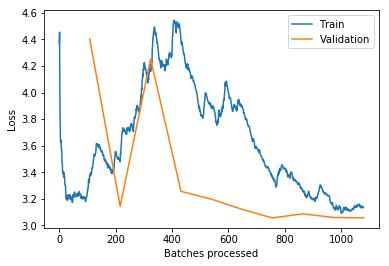

In [135]:
learn.recorder.plot_losses()

#### Stage 2-1

In [171]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


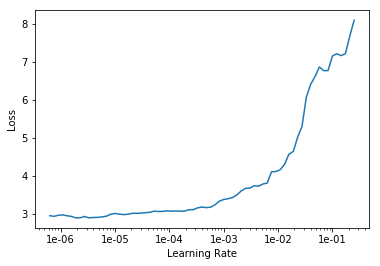

In [172]:
learn.lr_find()
learn.recorder.plot()

In [173]:
learn.fit_one_cycle(50, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,mse,mae,time
0,3.085015,2.973779,13.271718,2.960855,00:19
1,3.055214,2.952625,13.055230,2.943751,00:19
2,3.048696,2.960548,13.227463,2.956300,00:19
3,3.040686,2.953018,13.349487,2.972132,00:19
4,3.063181,3.033439,14.144627,3.031531,00:19
5,3.106212,3.338276,17.594528,3.338723,00:19
6,3.168639,3.094316,14.212359,3.012888,00:19
7,3.105437,3.064870,14.362647,3.058933,00:19
8,3.162057,3.238538,16.889671,3.298784,00:19
9,3.154899,2.990714,13.529201,2.972466,00:19


In [174]:
learn.save(save_path/f'{version}-stage-2-1')

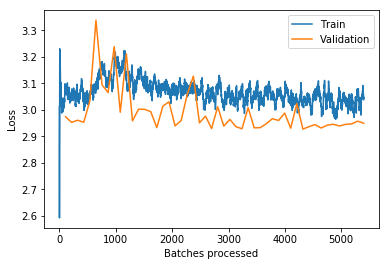

In [175]:
learn.recorder.plot_losses()

## SUBMISSION

In [176]:
# load sample submission
submission = pd.read_csv(path/'sample_submission.csv', index_col='seg_id')

In [177]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,0
seg_0012b5,0
seg_00184e,0
seg_003339,0
seg_0042cc,0


In [178]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [179]:
# assume order of test set is unchanged
submission['time_to_failure'] = [preds[i].item() for i in range(len(preds))]

In [180]:
submission.head()

,time_to_failure
seg_id,
seg_00030f,5.505983829498291
seg_0012b5,5.216168403625488
seg_00184e,5.215818405151367
seg_003339,5.403176784515381
seg_0042cc,5.397948741912842


In [183]:
min(submission['time_to_failure'])

-1.0948201417922974

In [184]:
max(submission['time_to_failure'])

12.88432788848877

In [185]:
submission.to_csv(path/'submission.csv')

In [187]:
# submit to leaderboard
! cd $path; kaggle competitions submit -c LANL-Earthquake-Prediction -f submission.csv -m "Message"

100%|██████████████████████████████████████| 74.4k/74.4k [00:02<00:00, 25.9kB/s]
Successfully submitted to LANL Earthquake Prediction

In [ ]:
# Public Score: 2.705